CSE 546 - Reinforcement Learning
# Assignment 1 - *Defining & Solving RL Environments*

## Prerequisites

*Installing required libraries*

In [1]:
!pip install gym

*Importing required libraries*

In [2]:
import gym
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt

from gym import spaces
from google.colab import widgets
from IPython.display import clear_output

*Initializing the positions of the agent, goal, and rewards*

In [3]:
AGENT_POS= [0, 0]
DIAMOND_POS= [1, 3]
COIN_POS= [3, 2]
MONSTER_POS= [2, 1]
GOAL_POS= [3, 3]

*Pre-defining the minimum number of states and actions that will be used in the environment*

In [4]:
N_STATES= 16
N_ACTIONS= 4
MAX_TIMESTEPS= 50

*Initializing lookup dictionaries for states & actions*

In [5]:
STATE_LOOKUP= dict()
ACTION_LOOKUP= {0: 'Down', 1: 'Up', 2: 'Right', 3: 'Left'}

k= 0
for i in range(4):
  for j in range(4):
    STATE_LOOKUP[(i, j)]= k
    k+= 1

## Deterministic Environment


*Defining a simple 4x4 deterministic environment*

In [6]:
class DeterministicEnvironment(gym.Env):
  metadata= {'render.modes': []}

  def __init__(self):
    '''
    Initializes the number of states, action, & maximum timestep of the environment
    '''

    self.observation_space= spaces.Discrete(N_STATES)
    self.action_space= spaces.Discrete(N_ACTIONS)
    self.max_timesteps= MAX_TIMESTEPS

  def reset(self):
    '''
    Resets the environment to its default setup

    Output:
      observation: 2-element list - Coordinates of the agent's default position in the grid
    '''

    self.timestep= 0

    self.agent_pos= AGENT_POS.copy()
    self.diamond_pos= DIAMOND_POS.copy()
    self.coin_pos= COIN_POS.copy()
    self.monster_pos= MONSTER_POS.copy()
    self.goal_pos= GOAL_POS.copy()

    self.state= np.zeros((4, 4))

    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10
    
    agent_state= self.agent_pos

    return STATE_LOOKUP[tuple(agent_state)]

  def step(self, action: int):
    '''
    1. Moves the agent as per the given action
    2. Sets the rewards per state in the environment
    3. Calculates the reward of the new state

    Input:
      action: int - Action to be performed

    Output:
      action: int - Action taken
      observation: 2-element list
      reward: int - State reward
      done: bool - Denotes if the learning is complete (or) goal is reached
      info: dict
    '''

    # Initializing the grid
    self.state= np.zeros((4, 4))

    # Move the agent
    if action == 0: # Go down one step
      self.agent_pos[0] += 1
    if action == 1: # Go up one step
      self.agent_pos[0] -= 1
    if action == 2: # Go right one step
      self.agent_pos[1] += 1
    if action == 3: # Go left one step
      self.agent_pos[1] -= 1

    # To keep the agent within the confines of the environment
    self.agent_pos= np.clip(self.agent_pos, 0, 3)

    # Initialize the state rewards
    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10

    agent_state= self.agent_pos

    # Calculates the reward for the action
    reward= 0
    if (self.agent_pos == self.diamond_pos).all():
      reward += 5
    if (self.agent_pos == self.coin_pos).all():
      reward += 3
    if (self.agent_pos == self.monster_pos).all():
      reward -= 5
    if (self.agent_pos == self.goal_pos).all():
      reward += 10

    # Timestep increment
    self.timestep += 1

    done= True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    info= {}

    return STATE_LOOKUP[tuple(agent_state)], reward, done, info

  def render(self):
    '''
    Provides pictorial representation of environment
    '''

    plt.imshow(self.state)

*Test render*

Current state : 0


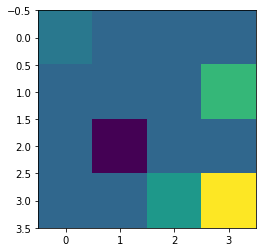

In [7]:
env= DeterministicEnvironment()
state= env.reset()
env.render()
print('Current state : {}'.format(state))

## Stochastic Environment


*Defining a simple 4x4 stochastic environment*

In [8]:
class StochasticEnvironment(gym.Env):
  metadata= {'render.modes': []}

  def __init__(self):
    '''
    Initializes the number of states, action, & maximum timestep of the environment
    '''

    self.observation_space= spaces.Discrete(N_STATES)
    self.action_space= spaces.Discrete(N_ACTIONS)
    self.max_timesteps= MAX_TIMESTEPS

  def reset(self):
    '''
    Resets the environment to its default setup

    Output:
      observation: 2-element list - Coordinates of the agent's default position in the grid
    '''

    self.timestep= 0

    self.agent_pos= AGENT_POS.copy()
    self.diamond_pos= DIAMOND_POS.copy()
    self.coin_pos= COIN_POS.copy()
    self.monster_pos= MONSTER_POS.copy()
    self.goal_pos= GOAL_POS.copy()

    self.state= np.zeros((4, 4))

    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10
    
    agent_state= self.agent_pos

    return STATE_LOOKUP[tuple(agent_state)]
  
  def step(self, action):
    '''
    1. Randomly chooses the action to be performed
    1. Moves the agent as per the chosen action
    2. Sets the rewards per state in the environment
    3. Calculates the reward of the new state

    Input:
      action: int - Action to be performed

    Output:
      action: int - Action taken
      observation: 2-element list
      reward: int - State reward
      done: bool - Denotes if the learning is complete (or) goal is reached
      info: dict
    '''

    # Initializing the grid
    self.state= np.zeros((4, 4))

    # Defining stochasticity to the environment
    action= action if random.uniform(0, 1) < 0.75 else random.choice([i for i in range(self.action_space.n) if i != action])

    # Move the agent
    if action == 0: # Go down one step
      self.agent_pos[0] += 1
    if action == 1: # Go up one step
      self.agent_pos[0] -= 1
    if action == 2: # Go right one step
      self.agent_pos[1] += 1
    if action == 3: # Go left one step
      self.agent_pos[1] -= 1

    # To keep the agent within the confines of the environment
    self.agent_pos= np.clip(self.agent_pos, 0, 3)

    # Initialize the state rewards
    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10

    agent_state= self.agent_pos

    # Calculates the reward for the action
    reward= 0
    if (self.agent_pos == self.diamond_pos).all():
      reward += 5
    if (self.agent_pos == self.coin_pos).all():
      reward += 3
    if (self.agent_pos == self.monster_pos).all():
      reward -= 5
    if (self.agent_pos == self.goal_pos).all():
      reward += 10

    # Timestep increment
    self.timestep += 1

    done= True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    info= {}

    return STATE_LOOKUP[tuple(agent_state)], reward, done, info

  def render(self):
    '''
    Provides pictorial representation of environment
    '''

    plt.imshow(self.state)

*Test render*

Current state : 0


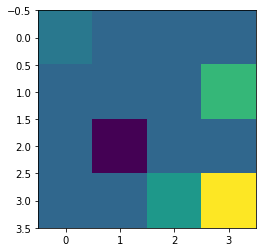

In [9]:
env= StochasticEnvironment()
state= env.reset()
env.render()
print('Current state : {}'.format(state))

## Random Agent

*Defining a random agent*

In [10]:
class RandomAgent:
  
  def __init__(self, env):
    self.env= env
    self.observation_space= env.observation_space
    self.action_space= env.action_space

  def step(self, state):
    return np.random.choice(self.action_space.n)

## Defining agents that learn using Tabular methods


### Q-learning agent

*Defining a Q learning agent*

In [11]:
# Subclass of the Random agent class
class QLearningAgent(RandomAgent):

  def __init__(self, env, discount_rate= 0.99, learning_rate= 0.01, epsilon= 1.0):
    '''
    '''
    super().__init__(env)

    # Sets the exploration, exploitation balance
    # Closer to 1.0 - exploration | Closer to 0.0 - exploitation
    self.epsilon= epsilon 

    # Sets the learning & decay parameters
    self.gamma= discount_rate
    self.alpha= learning_rate

    self.build_model()

  def build_model(self):
    '''
    '''
    self.Q_table= np.zeros((self.observation_space.n, self.action_space.n))

  def step(self, state: int):
    '''
    '''
    Q_state= self.Q_table[state]
    greedy_action= np.argmax(Q_state)
    random_action= super().step(state)

    # Depending on the epsilon value greedy or random action is chosen
    return random_action if random.random() < self.epsilon else greedy_action

  def train(self, experience: tuple):
    '''
    '''
    state, action, next_state, reward, done= experience
    
    # Q-value calculation
    Q_next= np.zeros([self.action_space.n]) if done else self.Q_table[next_state]
    Q_value= reward + self.gamma * np.max(Q_next) - self.Q_table[state, action]
    self.Q_table[state, action] += self.alpha * Q_value

    if done:
      # Setting exponential epsilon decay to prefer exploitation over exploration
      self.epsilon= self.epsilon * 0.99

## Running various agents in environment

*Running the random agent in the Deterministic Environment*

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

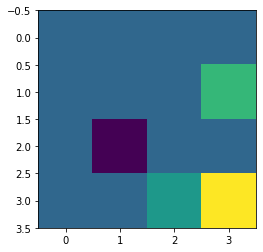

<IPython.core.display.Javascript object>

Agent has reached the Goal position
At the end of the run, the agent is at state 15 & got a total reward of 11


In [12]:
environment= DeterministicEnvironment()
random_agent= RandomAgent(env= environment)
state= environment.reset()
done= False

grid= widgets.Grid(1, 1)

total_reward= 0
while not done:
  action= random_agent.step(state= state)
  next_state, reward, done, info= environment.step(action= action)
  # print('By taking action \'{}\' the agent moved from {} to {} and got reward {}'.format(ACTION_LOOKUP[action], state, next_state, reward))
  state= next_state
  total_reward+= reward

  with grid.output_to(0, 0):
    grid.clear_cell()
    environment.render()
    # time.sleep(1)

if done == True and environment.timestep < MAX_TIMESTEPS:
  print('Agent has reached the Goal position')
elif done == True and environment.timestep == MAX_TIMESTEPS:
  print('Agent ran out of time')

print('At the end of the run, the agent is at state {} & got a total reward of {}'.format(state, total_reward))

*Running the random agent in the Stochastic Environment*

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

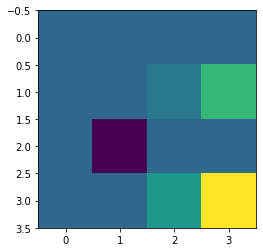

<IPython.core.display.Javascript object>

Agent ran out of time
At the end of the run, the agent got is at state 6 & a total reward of -2


In [13]:
environment= StochasticEnvironment()
random_agent= RandomAgent(env= environment)
state= environment.reset()
done= False

grid= widgets.Grid(1, 1)

total_reward= 0
while not done:
  action= random_agent.step(state= state)
  next_state, reward, done, info= environment.step(action= action)
  # print('By taking action \'{}\' the agent moved from {} to {} and got reward {}'.format(ACTION_LOOKUP[action], state, next_state, reward))
  state= next_state
  total_reward += reward

  with grid.output_to(0, 0):
    grid.clear_cell()
    environment.render()
    # time.sleep(1)

if done == True and environment.timestep < MAX_TIMESTEPS:
  print('Agent has reached the Goal position')
elif done == True and environment.timestep == MAX_TIMESTEPS:
  print('Agent ran out of time')

print('At the end of the run, the agent got is at state {} & a total reward of {}'.format(state, total_reward))

*Running the Q-learning random agent in the Deterministic Environment*

In [14]:
# Initializing the environment & the Q-learning agent
environment= DeterministicEnvironment()
Q_agent= QLearningAgent(env= environment)

In [15]:
# Metrics to calculate
reached= 0
not_reached= 0
total_reward= 0

for each_episode in range(10):
  state= environment.reset()
  done= False

  reward_per_episode= 0
  while not done:
    action= Q_agent.step(state= state)
    next_state, reward, done, info= environment.step(action= action)
    Q_agent.train(experience= (state, action, next_state, reward, done))
    state= next_state
    reward_per_episode += reward
    total_reward += reward

  if done == True and environment.timestep < MAX_TIMESTEPS:
    # Agent has reached the goal
    reached += 1
  elif done == True and environment.timestep == MAX_TIMESTEPS:
    # Agent ran out of time & has not reached the goal
    not_reached += 1
  print('Total reward obtained in episode {}: {}, and the epsilon value is {:.2f}'.format(each_episode+1, reward_per_episode, Q_agent.epsilon))

print('\nReached: {} & Not reached: {}'.format(reached, not_reached))
print('At the end of the run, the agent got is at state {} & a total reward of {}'.format(state, total_reward))

print('\nThe final q-table is')
print(Q_agent.Q_table)

Total reward obtained in episode 1: 19, and the epsilon value is 0.99
Total reward obtained in episode 2: 43, and the epsilon value is 0.98
Total reward obtained in episode 3: -18, and the epsilon value is 0.97
Total reward obtained in episode 4: 13, and the epsilon value is 0.96
Total reward obtained in episode 5: 1, and the epsilon value is 0.95
Total reward obtained in episode 6: 10, and the epsilon value is 0.94
Total reward obtained in episode 7: -5, and the epsilon value is 0.93
Total reward obtained in episode 8: -10, and the epsilon value is 0.92
Total reward obtained in episode 9: 4, and the epsilon value is 0.91
Total reward obtained in episode 10: 1, and the epsilon value is 0.90

Reached: 3 & Not reached: 7
At the end of the run, the agent got is at state 3 & a total reward of 58

The final q-table is
[[ 4.97773150e-06  3.59954198e-07  1.03681748e-05  5.00180255e-07]
 [ 2.36870835e-04  3.33074903e-06  1.47889601e-04  2.09037478e-07]
 [ 1.01398778e-02  9.75199500e-06  9.8505

## References
1. Reinforcement Learning: An Introduction by Richard S. Sutton & Andrew G. Barto - http://incompleteideas.net/book/RLbook2020.pdf
2. Q-learning [Wikipedia] - https://en.wikipedia.org/wiki/Q-learning
3. An Introduction to Q-Learning [Youtube] - https://youtu.be/wN3rxIKmMgE
4. Simple Reinforcement Learning: Q-learning - https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
5. Introduction to Various Reinforcement Learning Algorithms. Part I (Q-Learning, SARSA, DQN, DDPG) - https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287